# Gutenberg Chapters Dataset with CNN-Kim
CNN-Kim analysis with the Gutenberg chapters dataset. Using the following configuration:
1. Using Learned Embedding
1. Embedding size: 100
1. Using chapter length of 2,500
1. Top vocabulary count 5,000
1. Using filter sizes of 3, 4, 5, 6
1. Adam Learning Rate of 1e-4
1. L2-contraint 0.001

In [65]:
%matplotlib inline

import os
import sys
ai_lit_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
print("Loading AI Lit system from path", ai_lit_path)
sys.path.append(ai_lit_path)

import numpy as np
import pandas as pd
import tensorflow as tf

from ai_lit.analysis import analysis_util
from ai_lit.input.gutenberg_dataset import gb_input
from ai_lit.university.gutenberg import gb_chap_cnn_kim

Loading AI Lit system from path C:\Users\joewo\workspaces\python\ai_lit


In [2]:
# use the flags imported from the univserity and the model to set the configuration
tf.flags.FLAGS.chapter_length = 2500
tf.flags.FLAGS.vocab_count = 5000
tf.flags.FLAGS.embedding_size=100
tf.flags.FLAGS.epochs=10

dataset_wkspc = os.path.join(ai_lit_path, 'workspace', 'gb_input')
training_wkspc = os.path.join(ai_lit_path, 'workspace', 'gutenberg_chapters')
model_name = 'cnn_kim_l2_learned_embedding'
subjects = gb_input.get_subjects(dataset_wkspc)

In [ ]:
evaluation_name = 'standard_eval'
univ = gb_chap_cnn_kim.GbChaptersCnnKimUniversity(model_name, training_wkspc, dataset_wkspc)
accuracy, f1, cm = analysis_util.train_and_evaluate(univ, model_name, evaluation_name)

Validation Step 979
Targets:
[3 1 4 3 0 1 0 4 4 1 4 1 1 4 1 1 1 1 3 1]
Predictions:
[1 3 4 3 2 3 4 4 4 2 3 1 3 4 3 3 2 2 5 3]
Loss 2.0155, Acc 0.3

Testing examples exhausted
Shutting down all network threads
Checking validation mode... {'aggr_books': True}
Evaluating the full book aggregation.
Accuracy: 0.749285033365
F1: 0.71201759153


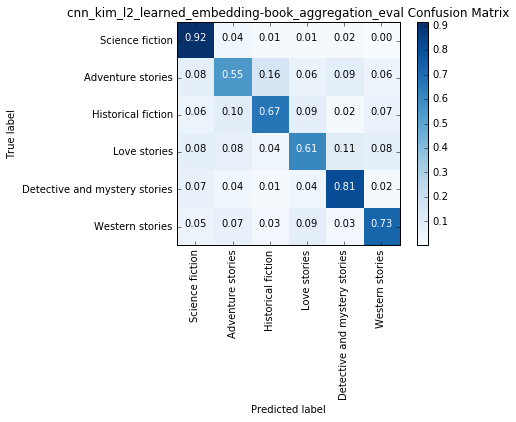

In [3]:
evaluation_name = 'book_aggregation_eval'
univ = gb_chap_cnn_kim.GbChaptersCnnKimUniversity(model_name, training_wkspc, dataset_wkspc)
accuracy, f1, cm = analysis_util.train_and_evaluate(univ, model_name, evaluation_name, **{"aggr_books": True})

In [19]:
df = pd.DataFrame([[book_id, record] for book_id, record in records.items()], columns=["book_id", "record"])

In [21]:
df['target'] = df['record'].apply(lambda r: r[0].target)
df['prediction'] = df['record'].apply(lambda r: np.bincount([c.pred for c in r]).argmax())

In [44]:
def get_chapter_distribution(records, bin_count):
    c_right = [0] * bin_count
    c_total = [0] * bin_count
    bins = np.arange(0, 1, 1/bin_count)
    for r in records:
        max_c = r[-1].chap_idx
        c_hist = np.digitize([c.chap_idx / max_c for c in r], bins=bins, right=True)
        for c, bin in zip(r, c_hist):
            if c.pred == c.target:
                c_right[bin-1] = c_right[bin-1] + 1
            c_total[bin-1] = c_total[bin-1] + 1
    return np.divide(c_right, c_total)

Science fiction


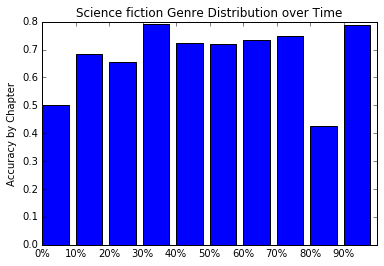

[ 0.5   0.68  0.65  0.79  0.72  0.72  0.73  0.75  0.43  0.79]

Adventure stories


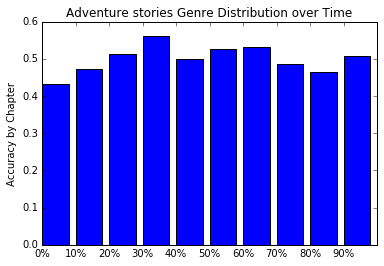

[ 0.43  0.47  0.51  0.56  0.5   0.53  0.53  0.48  0.47  0.51]

Historical fiction


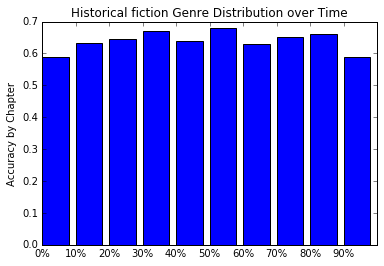

[ 0.59  0.63  0.65  0.67  0.64  0.68  0.63  0.65  0.66  0.59]

Love stories


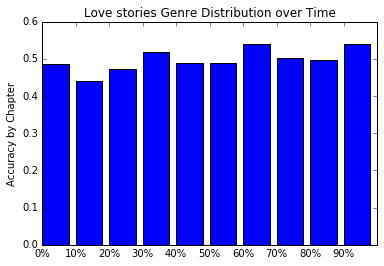

[ 0.49  0.44  0.47  0.52  0.49  0.49  0.54  0.5   0.5   0.54]

Detective and mystery stories


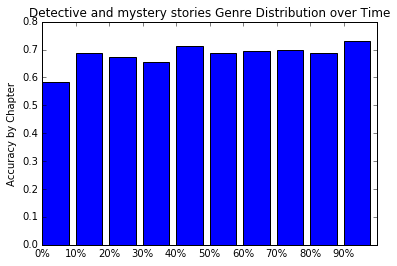

[ 0.58  0.69  0.67  0.66  0.71  0.69  0.69  0.7   0.69  0.73]

Western stories


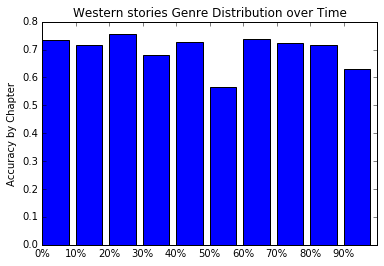

[ 0.74  0.72  0.76  0.68  0.73  0.57  0.74  0.72  0.72  0.63]



In [81]:
bar_locs = np.arange(0, 10, 1)
for i in range(0, len(subjects)):
    dist = get_chapter_distribution(df[df['target'] == i]['record'], 10)
    print(subjects[i])
    fig, ax = plt.subplots()
    ax.bar(bar_locs, dist, align="edge",
            tick_label=["0%", "10%", "20%", "30%", "40%",
                        "50%", "60%", "70%", "80%", "90%"])
    ax.set_ylabel('Accuracy by Chapter')
    ax.set_title("{} Genre Distribution over Time".format(subjects[i]))
    plt.xlim([0,10])
    plt.show()
    print(dist)
    print()